# Multivariate Time Series Forecasting using LSTM

**Author:** [Rohit Sahoo](https://www.linkedin.com/in/rohit-sahoo/)<Br>
**Date created:** 2021/07/15<Br>
**Last modified:** 2021/07/15<Br>
**Description:** Multivariate Time Series Forecasting on stock market data using LSTM.<Br>

## Introduction
Time-Series forecasting means predicting the future dependent variable (y) based on the past independent variable (x). If the model predicts a dependent variable (y) based on one independent variable (x), it is called univariate forecasting. Whereas, In Multivariate forecasting, the model predicts a dependent variable (y) based on more than one independent variable (x).

This Example implements a time series model for Google's stock market data. In this example, Multivariate time series forecasting is performed by determining the opening price of the stock using the historical opening, closing, highest, lowest and the adjusted closing price. This example uses the LSTM (Long Short-Term Memory) model to predict the opening price of the stock by taking the input shape defined by the window length and these 5 features.

A univariable forecast model reduces this complexity to a minimum – a single factor and ignores the other dimensions such as prediction of the opening price of the stock is based only on the historical opening price. Whereas, A multivariate stock market prediction model can consider the relationship between multiple variables. They offer a more detailed abstraction of reality than univariate models. Multivariate models thus tend to provide more accurate predictions than univariate models.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the Data

This example uses Google's stock market dataset downloaded from [Yahoo Finance](https://in.finance.yahoo.com/quote/GOOG/history?period1=1092960000&period2=1594944000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).

**Time-Frame Considered:** 16 Years of data starting from 2004/08/19 to 2020/07/17.

**Structure of Dataset**

1. Date - specifies trading date
2. Open - opening price
3. High - maximum price during the day
4. Low - minimum price during the day
5. Close - close price adjusted for splits
6. Adj Close - adjusted close price adjusted for both dividends and splits.
7. Volume - the number of shares that changed hands during a given day


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/rohit-sahoo/Multivariate_"+ \
    "Timeseries_Forecasting_using_LSTM/master/GOOG.csv")

In [3]:
print(df.head())

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  49.813286  51.835709  47.800831  49.982655  49.982655  44871300
1  2004-08-20  50.316402  54.336334  50.062355  53.952770  53.952770  22942800
2  2004-08-23  55.168217  56.528118  54.321388  54.495735  54.495735  18342800
3  2004-08-24  55.412300  55.591629  51.591621  52.239193  52.239193  15319700
4  2004-08-25  52.284027  53.798351  51.746044  52.802086  52.802086   9232100


In [5]:
print(df.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


The date column provided in the dataset is of object type, it has to be changed into datetime format.

In [6]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [7]:
print(df.describe()) #concise summary of the dataframe

              Open         High          Low        Close    Adj Close  \
count  4006.000000  4006.000000  4006.000000  4006.000000  4006.000000   
mean    519.588636   524.473898   514.551292   519.669776   519.669776   
std     369.380297   372.830122   366.249678   369.794911   369.794911   
min      49.409801    50.680038    47.800831    49.818268    49.818268   
25%     239.472400   241.624336   236.975514   239.440025   239.440025   
50%     336.583405   339.118897   333.425232   337.315659   337.315659   
75%     758.877487   767.349991   752.089997   759.529984   759.529984   
max    1550.000000  1577.131958  1521.400024  1541.739990  1541.739990   

             Volume  
count  4.006000e+03  
mean   6.916466e+06  
std    7.994278e+06  
min    7.900000e+03  
25%    1.718900e+06  
50%    4.216250e+06  
75%    8.821450e+06  
max    8.254150e+07  


**Visualizing the features**

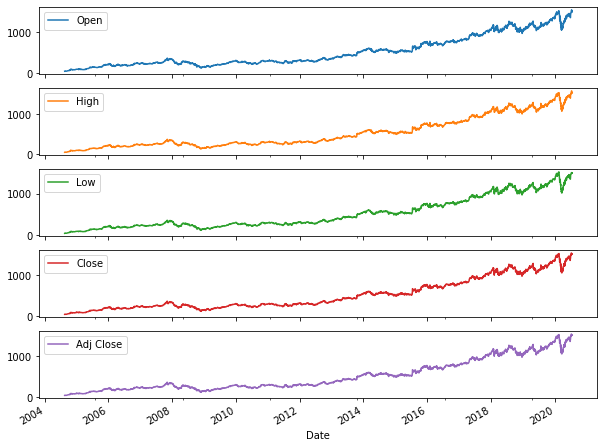

In [8]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
df.set_index('Date')[['Open','High','Low','Close','Adj Close']].plot(subplots=True);

Taking 5 features as the input to the time series - open, high, low, close, Adjusted close 

In [9]:
df_input=df[['Open','High','Low','Close','Adj Close',]]

In [13]:
print(df_input.describe())

              Open         High          Low        Close    Adj Close
count  4006.000000  4006.000000  4006.000000  4006.000000  4006.000000
mean    519.588636   524.473898   514.551292   519.669776   519.669776
std     369.380297   372.830122   366.249678   369.794911   369.794911
min      49.409801    50.680038    47.800831    49.818268    49.818268
25%     239.472400   241.624336   236.975514   239.440025   239.440025
50%     336.583405   339.118897   333.425232   337.315659   337.315659
75%     758.877487   767.349991   752.089997   759.529984   759.529984
max    1550.000000  1577.131958  1521.400024  1541.739990  1541.739990


# Prepare the Data
**StandardScaler()**

LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized.

Since there are 5 features used in this example for prediction and have different scales, they are Standardized to have a common scale while building the model.

StandardScaler() will normalize the features i.e. each column of X, INDIVIDUALLY, so that each column/feature/variable will have mean = 0 and standard deviation = 1

In [14]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
print(data_scaled)

[[-1.27195197 -1.26786213 -1.2745642  -1.27028724 -1.27028724]
 [-1.27058974 -1.26115415 -1.26838862 -1.2595499  -1.2595499 ]
 [-1.25745309 -1.25527464 -1.25675839 -1.25808143 -1.25808143]
 ...
 [ 2.71716347  2.71164316  2.68552176  2.68823148  2.68823148]
 [ 2.65453724  2.66700596  2.65359982  2.70002324  2.70002324]
 [ 2.713075    2.67974794  2.68666878  2.69339725  2.69339725]]


In [15]:
features=data_scaled
target=data_scaled[:,0] # Target Column - Open Price

In [16]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=123, shuffle = False)

In [17]:
print(x_train.shape)

(3004, 5)


In [18]:
print(x_test.shape)

(1002, 5)


**TimeseriesGenerator**

TimeseriesGenerator is used to automatically transform both univariate and multivariate time series data into samples, ready to train deep learning models.

In this example, Keras TimeseriesGenerator is used for preparing time series data for modelling with deep learning methods.

Arguments that are passed to TimeseriesGenerator:
1. features: Passing the scaled multivariate data
2. target: Passing the scaled target column
3. length: It is the window_length
4. Sampling_rate: Period between successive individual timesteps within sequences.
5. batch_size: Number of time-series samples in each batch

To know more about TimeseriesGenerator, check the Keras documentation: [TimeseriesGenerator](https://keras.io/api/preprocessing/timeseries/)

In [20]:
# This code block is for the understanding the output of TimeseriesGenerator
print("Input Features\n",data_scaled[0:3])
print("\nTimeseriesGenerator") 
print(TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0])

Input Features
 [[-1.27195197 -1.26786213 -1.2745642  -1.27028724 -1.27028724]
 [-1.27058974 -1.26115415 -1.26838862 -1.2595499  -1.2595499 ]
 [-1.25745309 -1.25527464 -1.25675839 -1.25808143 -1.25808143]]

TimeseriesGenerator
(array([[[-1.27195197, -1.26786213, -1.2745642 , -1.27028724,
         -1.27028724],
        [-1.27058974, -1.26115415, -1.26838862, -1.2595499 ,
         -1.2595499 ]]]), array([-1.25745309]))


From the above output, it can be observed that the opening price of 3rd day is made as the target value for the input features of first two days.

## Set the parameters and Build the model

In [22]:
win_length=60 #window length
batch_size=62
num_features=5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

**Leaky ReLU**

Leaky ReLU function is an improved version of the ReLU activation function. As for the ReLU activation function, the gradient is 0 for all the values of inputs that are less than zero, which would deactivate the neurons in that region and may cause a dying ReLU problem.

Leaky ReLU is defined to address this problem. Instead of defining the ReLU activation function as 0 for negative values of inputs(x), we define it as an extremely small linear component of x. Here is the formula for this activation function

f(x)=max(0.01*x , x)

For reference, Relu formula: f(x) = max(0,x)

This function returns x if it receives any positive input, but for any negative value of x, it returns a really small value which is 0.01 times x. 

**Why LSTM?**

Recurrent neural networks are much more flexible and much better suited to time series forecasting than the linear models usually applied. 

Recurrent neural networks, of which LSTMs (“long short-term memory” units) are the most powerful and well-known subset, are a type of artificial neural network designed to recognize patterns in sequences of data, such as numerical times series data.

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(1))

In [26]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           68608     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

# Train the model

In [27]:
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False)

Epoch 1/50
48/48 [==============================] - 11s 43ms/step - loss: 0.1878 - mean_absolute_error: 0.2952 - val_loss: 0.1769 - val_mean_absolute_error: 0.3104
Epoch 2/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0726 - mean_absolute_error: 0.2144 - val_loss: 0.1480 - val_mean_absolute_error: 0.3154
Epoch 3/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0748 - mean_absolute_error: 0.2134 - val_loss: 0.1425 - val_mean_absolute_error: 0.3072
Epoch 4/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0819 - mean_absolute_error: 0.2195 - val_loss: 0.4412 - val_mean_absolute_error: 0.5972
Epoch 5/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0564 - mean_absolute_error: 0.1818 - val_loss: 0.2201 - val_mean_absolute_error: 0.3809
Epoch 6/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0278 - mean_absolute_error: 0.1305 - val_loss: 0.0451 - val_mean_absolute_error: 0.1497
Epoch 7/50
48/48 [===

# Evaluate model on Test data

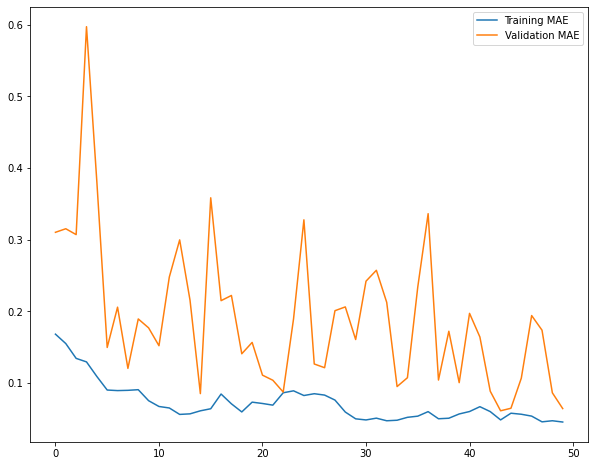

None


In [28]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.show()

Loss and Mean Absolute Error for test data

In [30]:
test_loss, test_mae = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Test Loss: 0.008368306793272495
Test MAE: 0.06448957324028015


## Predictions

In [31]:
predictions=model.predict(test_generator)

In [32]:
print(predictions.shape[0])

942


The shape of output is 942 and not 1002 when compared with x_test, since the first 60 days are used to determine the next day.

In [34]:
#Consider only the 942 values after the first 60 values
print(x_test[:,1:][win_length:])

[[0.75144424 0.77410068 0.76222089 0.76222089]
 [0.74975424 0.76863925 0.74996925 0.74996925]
 [0.73776344 0.76309581 0.75646021 0.75646021]
 ...
 [2.71164316 2.68552176 2.68823148 2.68823148]
 [2.66700596 2.65359982 2.70002324 2.70002324]
 [2.67974794 2.68666878 2.69339725 2.69339725]]


Concatenate the prediction dataframe with the x_test

In [35]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1) 

In [36]:
print(df_pred)

            0         0         1         2         3
0    0.732862  0.751444  0.774101  0.762221  0.762221
1    0.741900  0.749754  0.768639  0.749969  0.749969
2    0.753584  0.737763  0.763096  0.756460  0.756460
3    0.764269  0.779825  0.792642  0.793621  0.793621
4    0.776424  0.783849  0.793516  0.778908  0.778908
..        ...       ...       ...       ...       ...
937  2.422205  2.823778  2.705300  2.682011  2.682011
938  2.453695  2.678434  2.645926  2.707001  2.707001
939  2.473384  2.711643  2.685522  2.688231  2.688231
940  2.482835  2.667006  2.653600  2.700023  2.700023
941  2.482459  2.679748  2.686669  2.693397  2.693397

[942 rows x 5 columns]


**inverse_transform()** is used to scale back the data to the original representation.

In [37]:
# To get the original values, the inverse_transform has to be performed.
in_trans = scaler.inverse_transform(df_pred)

In [38]:
print(in_trans)

[[ 790.25967181  804.599976    798.030029    801.5         801.5       ]
 [ 793.59774772  803.969971    796.030029    796.969971    796.969971  ]
 [ 797.91280643  799.5         794.          799.369995    799.369995  ]
 ...
 [1433.09405362 1535.329956   1498.         1513.640015   1513.640015  ]
 [1436.58442262 1518.689941   1486.310059   1518.         1518.        ]
 [1436.44573421 1523.439941   1498.420044   1515.550049   1515.550049  ]]


In [39]:
#Get the last 942 rows to compare the actual opening price and the predicted opening price
df_final=df_input[predictions.shape[0]*-1:]

In [40]:
#Add the Predicted Open price into the final dataframe
predicted_open = in_trans[:,0].tolist()
df_final.insert(5, "Predicted Open", predicted_open)

In [41]:
print(df_final)

             Open         High          Low        Close    Adj Close  \
3064   798.239990   804.599976   798.030029   801.500000   801.500000   
3065   803.299988   803.969971   796.030029   796.969971   796.969971   
3066   795.000000   799.500000   794.000000   799.369995   799.369995   
3067   804.900024   815.179993   804.820007   813.109985   813.109985   
3068   816.679993   816.679993   805.140015   807.669983   807.669983   
...           ...          ...          ...          ...          ...   
4001  1550.000000  1577.131958  1505.243042  1511.339966  1511.339966   
4002  1490.310059  1522.949951  1483.500000  1520.579956  1520.579956   
4003  1523.130005  1535.329956  1498.000000  1513.640015  1513.640015   
4004  1500.000000  1518.689941  1486.310059  1518.000000  1518.000000   
4005  1521.619995  1523.439941  1498.420044  1515.550049  1515.550049   

      Predicted Open  
3064      790.259672  
3065      793.597748  
3066      797.912806  
3067      801.859482  
3068    

# Visualize the Actual values and Predicted values

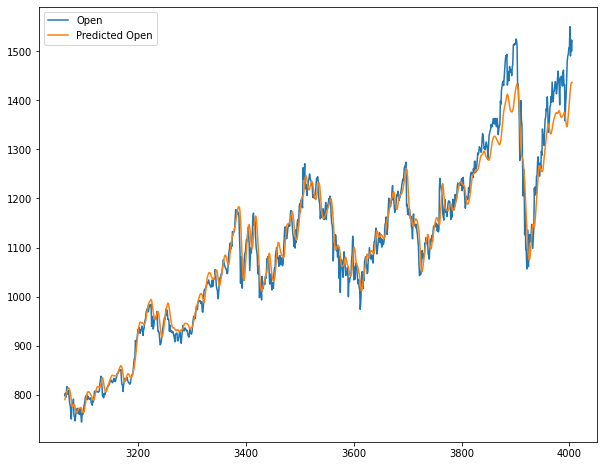

In [42]:
df_final[['Open','Predicted Open']].plot();